In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
from datetime import datetime
import re

import feature_eng
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import norm
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.grid_search import ParameterGrid, ParameterSampler, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import seaborn as sns
from xgboost import XGBClassifier

%matplotlib inline

print(pd.__version__)
print(sklearn.__version__)

0.18.1
0.17.1


[Go to experiments](#Experiments)

In [3]:
RAND_SEED_SPLIT = RAND_SEED_TUNING = 9161703
N_ITER_TUNING = 100

In [4]:
# df = pd.read_pickle('data/data-post.p')
# df.label = df.label.apply(pd.to_numeric)
# df = extract_features(df)
df = pd.read_csv('data/data_w_features.csv')
df['label'].value_counts()

0    22743
1     1859
Name: label, dtype: int64

In [5]:
df.describe()

,id,time,label,comments,likes,time_post,n_char,n_token,n_capital,n_number,n_emoji,n_unique_emoji,n_mention,%_capital,%_number,%_emoji,%_unique_emoji,log_char
count,2.460200e+04,2.460200e+04,24602.000000,24602.000000,24602.000000,2.460200e+04,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000
mean,1.785460e+16,1.458604e+09,0.075563,3898.954231,47677.054061,1.445165e+09,56.993415,9.026868,6.652305,1.184457,0.739208,0.390090,0.721283,0.064761,0.017669,0.033454,0.019734,3.391279
std,1.278845e+13,1.670100e+07,0.264303,7566.835904,56460.777801,2.271045e+07,102.058483,16.934521,31.435453,6.122488,2.687093,1.034963,0.895949,0.137148,0.078932,0.137256,0.091833,1.099910
min,1.784224e+16,1.375101e+09,0.000000,72.000000,227.000000,1.354197e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.785026e+16,1.450438e+09,0.000000,664.000000,10949.000000,1.432007e+09,15.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.708050
50%,1.785350e+16,1.463847e+09,0.000000,1475.000000,25972.000000,1.448722e+09,29.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.025641,0.000000,0.000000,0.000000,3.367296
75%,1.785843e+16,1.471747e+09,0.000000,4488.000000,67953.250000,1.463973e+09,55.000000,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.055556,0.000000,0.000000,0.000000,4.007333
max,1.810824e+16,1.475015e+09,1.000000,116226.000000,485577.000000,1.474420e+09,1490.000000,228.000000,722.000000,109.000000,88.000000,15.000000,10.000000,1.000000,1.000000,1.000000,1.000000,7.306531


In [5]:
train, validate, test = np.split(df.sample(frac=1, random_state=RAND_SEED_SPLIT), [int(.6 * len(df)), int(.8 * len(df))])
train, validate, test = train.reset_index(drop=True), validate.reset_index(drop=True), test.reset_index(drop=True)
pd.DataFrame([train['label'].value_counts(),
              validate['label'].value_counts(),
              test['label'].value_counts()],
             index=['train', 'val', 'test'])

,0,1
train,13667,1094
val,4549,371
test,4527,394


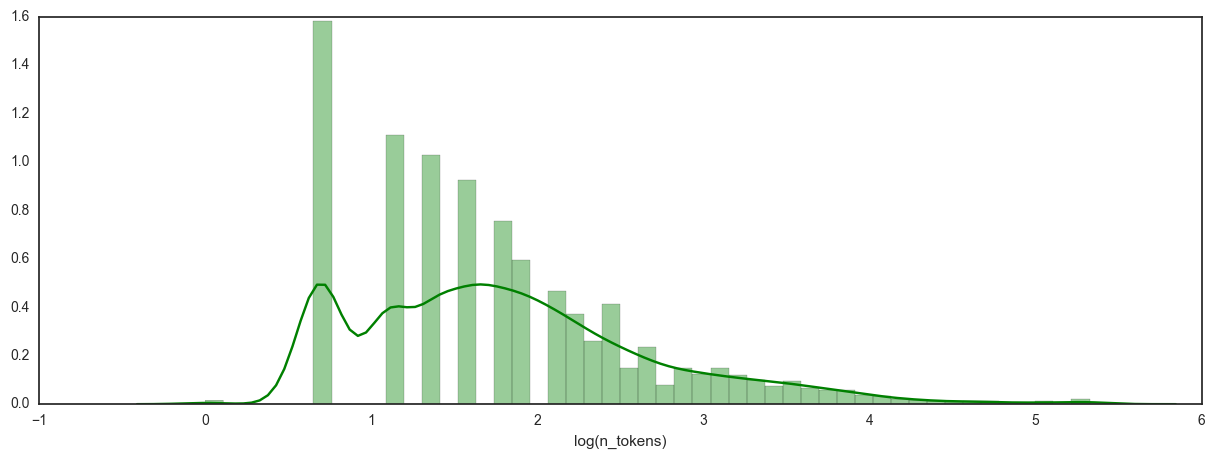

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(train.n_token.apply(lambda x: np.log(x + 1)), color='g', ax=ax)
plt.xlabel('log(n_tokens)')
plt.show()

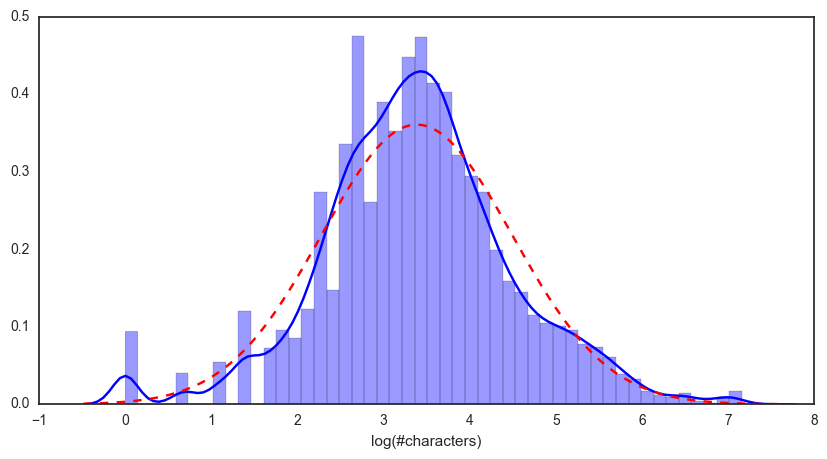

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(train.n_char.apply(np.log), fit=norm, fit_kws={'linestyle': '--', 'color': 'r'}, color='b', ax=ax)
plt.xlabel('log(#characters)')
plt.show()

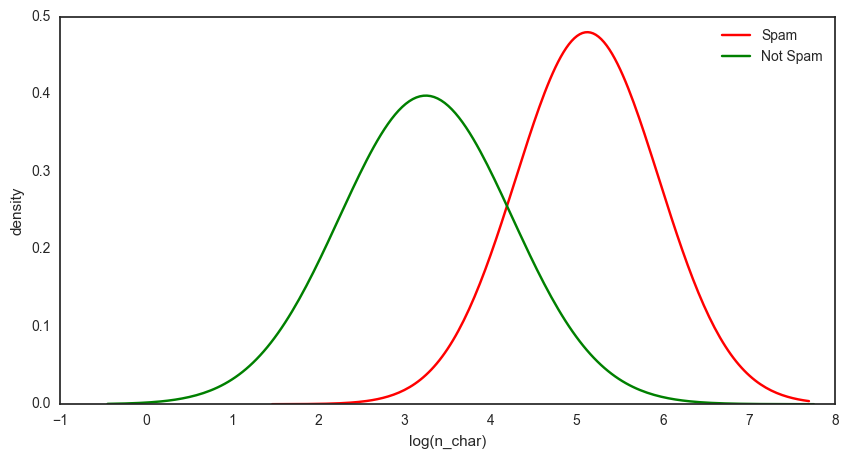

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
# sns.distplot(np.log(validate[validate.label == 1].n_char), kde=True, kde_kws={'alpha': 0}, hist_kws={'color': 'r'}, hist=True)
# sns.distplot(np.log(validate[validate.label == 0].n_char), kde=True, kde_kws={'alpha': 0}, hist_kws={'color': 'g'}, hist=True)
sns.distplot(np.log(train[train.label == 1].n_char), kde=False, hist=False, fit=norm, fit_kws={'color': 'r', 'label': 'Spam'})
sns.distplot(np.log(train[train.label == 0].n_char), kde=False, hist=False, fit=norm, fit_kws={'color': 'g', 'label': 'Not Spam'})
plt.legend()
plt.xlabel('log(n_char)')
plt.ylabel('density')
plt.savefig('by_length.eps', format='eps', dpi=1000)
plt.show()

In [8]:
train.to_pickle('data/train.p')
validate.to_pickle('data/validate.p')
test.to_pickle('data/test.p')

# Experiments

In [17]:
train = pd.read_pickle('data/train.p')
validate = pd.read_pickle('data/validate.p')
test = pd.read_pickle('data/test.p')

In [6]:
PARAM_DISTRIBS = {
    BernoulliNB: {
        'fit_prior': [True, False],
    },
    GaussianNB: {},
    SVC: {
        'C': [2**e for e in [-5, -3, 0, 3, 5, 7, 9]],
        'gamma': [2**e for e in [-9, -7, -5, -3, 0, 3, 5, 7, 9]],
    },
    XGBClassifier: {
        'n_estimators': [10, 20, 50, 100],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.],
        'reg_alpha': [0., 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1., 5., 10.],
        'reg_lambda': [0., 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1., 5., 10.],
        'scale_pos_weight': np.linspace(1., (train['label'] == 0).sum() / train['label'].sum(), 10)
    },
}

f = [
    'n_token',
    'n_capital',
    'n_emoji',
    'n_unique_emoji',
    'n_number',
    'n_mention',
    '%_capital',
    '%_number',
    '%_emoji',
    '%_unique_emoji',
    'log_char',
    'has_phone_number',
    'has_bbm_pin',
]

keywords = list(map(lambda x: 'has_pattern_' + x, feature_eng.SPAMMY_PATTERNS))

In [7]:
def classify(X_train, y_train, X_val, y_val, classifiers):
    metrics = []
    for name, clf in classifiers:
        clf.fit(X_train, y_train)

        predicted = clf.predict(X_val)

        precision = precision_score(y_val, predicted)
        recall = recall_score(y_val, predicted)
        f1 = f1_score(y_val, predicted)

        metrics.append([name, precision, recall, f1])

    return pd.DataFrame(metrics, columns=['classifier','precision','recall','f1']).set_index('classifier') * 100


def classify(X_train, y_train, X_val, y_val, clf_class, param_grid=None, n_iter=100, rand_seed=None):
    if clf_class == SVC:
        scaler = MinMaxScaler(feature_range=(0., 1.))
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    
    if not param_grid:
        param_grid = PARAM_DISTRIBS[clf_class]
    n_iter = min(n_iter, len(ParameterGrid(param_grid)))
    
    clf = RandomizedSearchCV(clf_class(), param_grid, n_iter=n_iter, n_jobs=4, cv=2, scoring='f1', random_state=rand_seed)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_val)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, warn_for=())
    return clf.best_params_, {'precision': precision[1], 'recall': recall[1], 'f1': f1[1]}

def classify_multiple_clfs(X_train, y_train, X_val, y_val, clf_classes, cls_param_grids=None, n_iter=100, rand_seed=None):
    if not cls_param_grids:
        cls_param_grids = dict()
    
    result = {cls: classify(X_train, y_train, X_val, y_val, cls, param_grid=cls_param_grids.get(cls), n_iter=n_iter, rand_seed=rand_seed) for cls in clf_classes}
    best_params = {cls: res[0] for cls, res in result.items()}
    
    metrics = pd.DataFrame({cls: res[1] for cls, res in result.items()}).T
    metrics.index = [_.__name__ for _ in metrics.index]
    metrics = metrics.sort_index()
    
    return best_params, metrics

In [8]:
X_train_orig = pd.concat([train, validate], ignore_index=True)
y_train = X_train_orig['label']
y_test = test['label']

In [9]:
import warnings
warnings.filterwarnings('ignore', message='.*is ill-defined', append=True)
warnings.filterwarnings('ignore', category=DeprecationWarning)

## A: Hand-engineered features

### Basic

In [10]:
X_train, X_test = X_train_orig[f], test[f]

best_params_basic, metrics_basic = classify_multiple_clfs(X_train, y_train, X_test, y_test,
                                                          [GaussianNB, SVC, XGBClassifier],
                                                          n_iter=N_ITER_TUNING, rand_seed=RAND_SEED_TUNING)
metrics_basic

,f1,precision,recall
GaussianNB,0.666667,0.690217,0.644670
SVC,0.768778,0.915789,0.662437
XGBClassifier,0.777457,0.902685,0.682741


### Keywords

In [11]:
X_train, X_test = X_train_orig[keywords], test[keywords]

best_params_keywords, metrics_keywords = classify_multiple_clfs(X_train, y_train, X_test, y_test,
                                                                [BernoulliNB, SVC, XGBClassifier],
                                                                n_iter=N_ITER_TUNING, rand_seed=RAND_SEED_TUNING)
metrics_keywords

,f1,precision,recall
BernoulliNB,0.839080,0.966887,0.741117
SVC,0.872629,0.936047,0.817259
XGBClassifier,0.865465,0.954128,0.791878


### Basic + Keywords

In [12]:
X_train, X_test = X_train_orig[f + keywords], test[f + keywords]

best_params_A, metrics_A = classify_multiple_clfs(X_train, y_train, X_test, y_test,
                                                  [GaussianNB, SVC, XGBClassifier],
                                                  n_iter=N_ITER_TUNING, rand_seed=RAND_SEED_TUNING)
metrics_A

,f1,precision,recall
GaussianNB,0.877193,0.866337,0.888325
SVC,0.909333,0.957865,0.865482
XGBClassifier,0.908851,0.947658,0.873096


## B: Text features

### BoW

In [13]:
bow_pipeline = Pipeline([
        ('CountVectorizer', CountVectorizer(min_df=5, binary=True)),
        ('LSA', TruncatedSVD(n_components=100)),
    ])
bow_pipeline.fit(train['text'])

X_train_bow, X_test_bow = bow_pipeline.transform(X_train_orig['text']), bow_pipeline.transform(test['text'])

best_params_bow, metrics_bow = classify_multiple_clfs(X_train_bow, y_train, X_test_bow, y_test,
                                                        [GaussianNB, SVC, XGBClassifier],
                                                        n_iter=N_ITER_TUNING, rand_seed=RAND_SEED_TUNING)
metrics_bow

,f1,precision,recall
GaussianNB,0.536100,0.398274,0.819797
SVC,0.907357,0.979412,0.845178
XGBClassifier,0.912145,0.928947,0.895939


### TFIDF

In [23]:
tfidf_pipeline = Pipeline([
        ('TfidfVectorizer', TfidfVectorizer(min_df=5)),
        ('LSA', TruncatedSVD(n_components=100)),
    ])
tfidf_pipeline.fit(train['text'])

X_train_tfidf, X_test_tfidf = tfidf_pipeline.transform(X_train_orig['text']), tfidf_pipeline.transform(test['text'])

best_params_tfidf, metrics_tfidf = classify_multiple_clfs(X_train_tfidf, y_train, X_test_tfidf, y_test,
                                                        [GaussianNB, SVC, XGBClassifier],
                                                        n_iter=N_ITER_TUNING, rand_seed=RAND_SEED_TUNING)
metrics_tfidf

,f1,precision,recall
GaussianNB,0.238520,0.136397,0.949239
SVC,0.907407,0.947514,0.870558
XGBClassifier,0.908861,0.906566,0.911168


### Fasttext

In [24]:
# ftext_skipgram = feature_eng.train_model_fasttext(feature_eng.tokenize(train['text']),
#                                                   file_in='tmp/fasttext_train.txt',
#                                                   path_out='models/fasttext_skipgram')

In [25]:
# Fasttext
X_train_ftext = feature_eng.extract_fasttext(X_train_orig['text'], fpath_model='models/fasttext_skipgram.bin').reset_index(drop=True)
X_test_ftext = feature_eng.extract_fasttext(test['text'], fpath_model='models/fasttext_skipgram.bin').reset_index(drop=True)

best_params_ftext, metrics_ftext = classify_multiple_clfs(X_train_ftext, y_train, X_test_ftext, y_test,
                                                            [GaussianNB, SVC, XGBClassifier],
                                                            n_iter=N_ITER_TUNING, rand_seed=RAND_SEED_TUNING)
metrics_ftext

,f1,precision,recall
GaussianNB,0.824945,0.725000,0.956853
SVC,0.939821,0.948320,0.931472
XGBClassifier,0.924841,0.928389,0.921320


## C: Hand-engineered + text features

### BoW + Basic

In [26]:
X_train = pd.concat([pd.DataFrame(X_train_bow), X_train_orig[f]], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_bow), test[f]], axis=1)

best_params_bow_f, metrics_bow_f = classify_multiple_clfs(X_train, y_train, X_test, y_test,
                                                          [GaussianNB, SVC, XGBClassifier],
                                                          n_iter=N_ITER_TUNING, rand_seed=RAND_SEED_TUNING)
metrics_bow_f

,f1,precision,recall
GaussianNB,0.580247,0.444595,0.835025
SVC,0.939948,0.967742,0.913706
XGBClassifier,0.926829,0.937662,0.916244


### BoW + Basic + Keywords

In [27]:
X_train = pd.concat([pd.DataFrame(X_train_bow), X_train_orig[f + keywords]], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_bow), test[f + keywords]], axis=1)

best_params_bow_f_keywords, metrics_bow_f_keywords = classify_multiple_clfs(X_train, y_train, X_test, y_test,
                                                                            [GaussianNB, SVC, XGBClassifier],
                                                                            n_iter=N_ITER_TUNING,
                                                                            rand_seed=RAND_SEED_TUNING)
metrics_bow_f_keywords

,f1,precision,recall
GaussianNB,0.736621,0.627907,0.890863
SVC,0.930851,0.977654,0.888325
XGBClassifier,0.938144,0.952880,0.923858


### TFIDF + Basic

In [28]:
X_train = pd.concat([pd.DataFrame(X_train_tfidf), X_train_orig[f]], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_tfidf), test[f]], axis=1)

best_params_tfidf_f, metrics_tfidf_f = classify_multiple_clfs(X_train, y_train, X_test, y_test,
                                                              [GaussianNB, SVC, XGBClassifier],
                                                              n_iter=N_ITER_TUNING, rand_seed=RAND_SEED_TUNING)
metrics_tfidf_f

,f1,precision,recall
GaussianNB,0.733119,0.634508,0.868020
SVC,0.937337,0.965054,0.911168
XGBClassifier,0.937738,0.938931,0.936548


### TFIDF + Basic + Keywords

In [29]:
X_train = pd.concat([pd.DataFrame(X_train_tfidf), X_train_orig[f + keywords]], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_tfidf), test[f + keywords]], axis=1)

best_params_tfidf_f_keywords, metrics_tfidf_f_keywords = classify_multiple_clfs(X_train, y_train, X_test, y_test,
                                                                                [GaussianNB, SVC, XGBClassifier],
                                                                                n_iter=N_ITER_TUNING,
                                                                                rand_seed=RAND_SEED_TUNING)
metrics_tfidf_f_keywords

,f1,precision,recall
GaussianNB,0.881773,0.856459,0.908629
SVC,0.934896,0.959893,0.911168
XGBClassifier,0.943590,0.953368,0.934010


### Fasttext + Basic

In [43]:
X_train = pd.concat([pd.DataFrame(X_train_ftext), X_train_orig[f]], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_ftext), test[f]], axis=1)

best_params_ftext_f, metrics_ftext_f = classify_multiple_clfs(X_train, y_train, X_test, y_test,
                                                              [GaussianNB, SVC, XGBClassifier],
                                                              n_iter=N_ITER_TUNING, rand_seed=RAND_SEED_TUNING)
metrics_ftext_f

,f1,precision,recall
GaussianNB,0.862109,0.793177,0.944162
SVC,0.952258,0.968504,0.936548
XGBClassifier,0.951189,0.938272,0.964467


### Fasttext + Basic + Keywords

In [31]:
X_train = pd.concat([pd.DataFrame(X_train_ftext), X_train_orig[f + keywords]], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_ftext), test[f + keywords]], axis=1)

best_params_ftext_f_keywords, metrics_ftext_f_keywords = classify_multiple_clfs(X_train, y_train, X_test, y_test,
                                                              [GaussianNB, SVC, XGBClassifier],
                                                              n_iter=N_ITER_TUNING, rand_seed=RAND_SEED_TUNING)
metrics_ftext_f_keywords

,f1,precision,recall
GaussianNB,0.880096,0.834091,0.931472
SVC,0.960103,0.973890,0.946701
XGBClassifier,0.951189,0.938272,0.964467


## All params for reproduction

In [51]:
best_params_basic

{sklearn.naive_bayes.GaussianNB: {},
 sklearn.svm.classes.SVC: {'C': 1, 'gamma': 32},
 xgboost.sklearn.XGBClassifier: {'colsample_bytree': 0.9,
  'n_estimators': 100,
  'reg_alpha': 0.001,
  'reg_lambda': 0.01,
  'scale_pos_weight': 1.0,
  'subsample': 0.6}}

In [52]:
best_params_keywords

{xgboost.sklearn.XGBClassifier: {'colsample_bytree': 0.8,
  'n_estimators': 100,
  'reg_alpha': 0.005,
  'reg_lambda': 0.0,
  'scale_pos_weight': 2.2769652650822669,
  'subsample': 0.9},
 sklearn.svm.classes.SVC: {'C': 0.125, 'gamma': 1},
 sklearn.naive_bayes.BernoulliNB: {'fit_prior': True}}

In [53]:
best_params_A

{sklearn.naive_bayes.GaussianNB: {},
 sklearn.svm.classes.SVC: {'C': 32, 'gamma': 8},
 xgboost.sklearn.XGBClassifier: {'colsample_bytree': 0.8,
  'n_estimators': 100,
  'reg_alpha': 0.005,
  'reg_lambda': 0.0,
  'scale_pos_weight': 2.2769652650822669,
  'subsample': 0.9}}

In [54]:
best_params_bow

{sklearn.naive_bayes.GaussianNB: {},
 sklearn.svm.classes.SVC: {'C': 32, 'gamma': 0.125},
 xgboost.sklearn.XGBClassifier: {'colsample_bytree': 1.0,
  'n_estimators': 100,
  'reg_alpha': 0.05,
  'reg_lambda': 0.5,
  'scale_pos_weight': 3.5539305301645339,
  'subsample': 0.6}}

In [55]:
best_params_tfidf

{sklearn.naive_bayes.GaussianNB: {},
 sklearn.svm.classes.SVC: {'C': 8, 'gamma': 1},
 xgboost.sklearn.XGBClassifier: {'colsample_bytree': 1.0,
  'n_estimators': 100,
  'reg_alpha': 0.05,
  'reg_lambda': 0.5,
  'scale_pos_weight': 3.5539305301645339,
  'subsample': 0.6}}

In [56]:
best_params_ftext

{sklearn.naive_bayes.GaussianNB: {},
 sklearn.svm.classes.SVC: {'C': 8, 'gamma': 1},
 xgboost.sklearn.XGBClassifier: {'colsample_bytree': 0.9,
  'n_estimators': 100,
  'reg_alpha': 0.001,
  'reg_lambda': 0.01,
  'scale_pos_weight': 1.0,
  'subsample': 0.6}}

In [57]:
best_params_bow_f

{sklearn.naive_bayes.GaussianNB: {},
 sklearn.svm.classes.SVC: {'C': 8, 'gamma': 1},
 xgboost.sklearn.XGBClassifier: {'colsample_bytree': 0.5,
  'n_estimators': 100,
  'reg_alpha': 1.0,
  'reg_lambda': 0.1,
  'scale_pos_weight': 3.5539305301645339,
  'subsample': 0.7}}

In [58]:
best_params_bow_f_keywords

{sklearn.naive_bayes.GaussianNB: {},
 sklearn.svm.classes.SVC: {'C': 32, 'gamma': 0.125},
 xgboost.sklearn.XGBClassifier: {'colsample_bytree': 0.6,
  'n_estimators': 100,
  'reg_alpha': 0.05,
  'reg_lambda': 0.05,
  'scale_pos_weight': 3.5539305301645339,
  'subsample': 0.8}}

In [59]:
best_params_tfidf_f

{sklearn.naive_bayes.GaussianNB: {},
 sklearn.svm.classes.SVC: {'C': 8, 'gamma': 1},
 xgboost.sklearn.XGBClassifier: {'colsample_bytree': 0.6,
  'n_estimators': 100,
  'reg_alpha': 0.05,
  'reg_lambda': 0.05,
  'scale_pos_weight': 3.5539305301645339,
  'subsample': 0.8}}

In [60]:
best_params_tfidf_f_keywords

{sklearn.naive_bayes.GaussianNB: {},
 sklearn.svm.classes.SVC: {'C': 128, 'gamma': 1},
 xgboost.sklearn.XGBClassifier: {'colsample_bytree': 0.5,
  'n_estimators': 100,
  'reg_alpha': 1.0,
  'reg_lambda': 0.1,
  'scale_pos_weight': 3.5539305301645339,
  'subsample': 0.7}}

In [61]:
best_params_ftext_f

{sklearn.naive_bayes.GaussianNB: {},
 sklearn.svm.classes.SVC: {'C': 128, 'gamma': 0.03125},
 xgboost.sklearn.XGBClassifier: {'colsample_bytree': 0.5,
  'n_estimators': 100,
  'reg_alpha': 1.0,
  'reg_lambda': 0.1,
  'scale_pos_weight': 3.5539305301645339,
  'subsample': 0.7}}

In [62]:
best_params_ftext_f_keywords

{sklearn.naive_bayes.GaussianNB: {},
 sklearn.svm.classes.SVC: {'C': 512, 'gamma': 0.0078125},
 xgboost.sklearn.XGBClassifier: {'colsample_bytree': 0.6,
  'n_estimators': 100,
  'reg_alpha': 0.05,
  'reg_lambda': 0.05,
  'scale_pos_weight': 3.5539305301645339,
  'subsample': 0.8}}

---

# Old

In [118]:
X_train = pd.concat([pd.DataFrame(X_train_ftext), X_train_orig[f + keywords]], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_ftext), test[f + keywords]], axis=1)

best_params_ftext_f_keywords, metrics_ftext_f_keywords = classify_2_multiple_clfs(X_train, y_train, X_test, y_test,
                                                                                  [GaussianNB, SVC, XGBClassifier],
                                                                                  n_iter=n_iter, rand_seed=rand_seed_tuning)
metrics_ftext_f_keywords

,f1,precision,recall
GaussianNB,0.883273,0.839817,0.931472
SVC,0.928947,0.964481,0.895939
XGBClassifier,0.891735,0.823656,0.972081


In [11]:
X_train = pd.concat([train[f], extract_fasttext(train.text)], axis=1)
X_val = pd.concat([validate[f], extract_fasttext(validate.text)], axis=1)
y_train = train['label']
y_val = validate['label']

print(classify(X_train, y_train, X_val, y_val, classifiers))

             precision     recall         f1
classifier                                  
Naive Bayes  78.947368  93.243243  85.501859
SVM          94.223827  70.540541  80.680062
XGBoost      95.786517  92.162162  93.939394


In [12]:
X_train = pd.concat([train[f + keywords], extract_fasttext(train.text)], axis=1)
X_val = pd.concat([validate[f + keywords], extract_fasttext(validate.text)], axis=1)
y_train = train['label']
y_val = validate['label']

print(classify(X_train, y_train, X_val, y_val, classifiers))

             precision     recall         f1
classifier                                  
Naive Bayes  84.615385  95.135135  89.567430
SVM          96.439169  87.837838  91.937765
XGBoost      95.821727  92.972973  94.375857


## Bag of Words

In [14]:
X_train = X.toarray()
X_val = vectorizer.transform(validate.text).toarray()
y_train = train['label']
y_val = validate['label']

print(classify(X_train, y_train, X_val, y_val, classifiers))

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


             precision     recall         f1
classifier                                  
Naive Bayes  84.239130  83.783784  84.010840
SVM          98.076923  27.567568  43.037975
XGBoost      97.009967  78.918919  87.034277


## Latent Semantic Analysis

In [10]:
classifiers = [
    ('Naive Bayes', GaussianNB()),
    ('SVM', Pipeline([
        ('min/max scaler', MinMaxScaler(feature_range=(0.0, 1.0))),
        ('SVM', SVC())])),
    ('XGBoost', XGBClassifier())
]

In [11]:
svd = TruncatedSVD(n_components=100)

X_train = svd.fit_transform(X)
X_val = svd.transform(vectorizer.transform(validate.text))
y_train = train['label']
y_val = validate['label']

print(classify(X_train, y_train, X_val, y_val, classifiers))

             precision     recall         f1
classifier                                  
Naive Bayes  41.136671  82.162162  54.824166
SVM          98.387097  49.459459  65.827338
XGBoost      96.604938  84.594595  90.201729


In [9]:
X_train = pd.concat([train[f].reset_index(), pd.DataFrame(X_train)], axis=1).drop('index', axis=1)
X_val = pd.concat([validate[f].reset_index(), pd.DataFrame(X_val)], axis=1).drop('index', axis=1)

print(classify(X_train, y_train, X_val, y_val, classifiers))

             precision     recall         f1
classifier                                  
Naive Bayes  38.231631  82.972973  52.344416
SVM          98.507463  53.513514  69.352014
XGBoost      96.783626  89.459459  92.977528


In [12]:
X_train = pd.concat([train[f + keywords].reset_index(), pd.DataFrame(X_train)], axis=1).drop('index', axis=1)
X_val = pd.concat([validate[f + keywords].reset_index(), pd.DataFrame(X_val)], axis=1).drop('index', axis=1)

print(classify(X_train, y_train, X_val, y_val, classifiers))

             precision     recall         f1
classifier                                  
Naive Bayes  62.201835  91.621622  74.098361
SVM          97.763578  82.702703  89.604685
XGBoost      97.109827  90.810811  93.854749


## TF-IDF

In [6]:
vectorizer = TfidfVectorizer(min_df=5)
X = vectorizer.fit_transform(train.text)

In [7]:
X_train = X.toarray()
X_val = vectorizer.transform(validate.text).toarray()
y_train = train['label']
y_val = validate['label']

print(classify(X_train, y_train, X_val, y_val, classifiers))

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision     recall         f1
classifier                                  
Naive Bayes  14.751958  91.621622  25.412294
SVM           0.000000   0.000000   0.000000
XGBoost      97.643098  78.378378  86.956522


## Latent Semantic Analysis

In [8]:
svd = TruncatedSVD(n_components=100)

X_train = svd.fit_transform(X)
X_val = svd.transform(vectorizer.transform(validate.text))
y_train = train['label']
y_val = validate['label']

print(classify(X_train, y_train, X_val, y_val, classifiers))

             precision     recall         f1
classifier                                  
Naive Bayes  11.856205  92.702703  21.023598
SVM          98.630137  19.459459  32.505643
XGBoost      93.865031  82.702703  87.931034


In [11]:
X_train = pd.concat([train[f].reset_index(), pd.DataFrame(X_train)], axis=1).drop('index', axis=1)
X_val = pd.concat([validate[f].reset_index(), pd.DataFrame(X_val)], axis=1).drop('index', axis=1)

print(classify(X_train, y_train, X_val, y_val, classifiers))

             precision     recall         f1
classifier                                  
Naive Bayes  65.843621  86.486486  74.766355
SVM          95.481928  85.675676  90.313390
7NN          91.438356  72.162162  80.664653
XGBoost      96.726190  87.837838  92.067989


In [25]:
X_train = pd.concat([train[f + keywords].reset_index(), pd.DataFrame(X_train)], axis=1).drop('index', axis=1)
X_val = pd.concat([validate[f + keywords].reset_index(), pd.DataFrame(X_val)], axis=1).drop('index', axis=1)

print(classify(X_train, y_train, X_val, y_val, classifiers))

             precision     recall         f1
classifier                                  
Naive Bayes  83.932854  94.594595  88.945362
SVM          96.285714  91.081081  93.611111
7NN          93.706294  72.432432  81.707317
XGBoost      97.159091  92.432432  94.736842


# Testing

In [6]:
tv = pd.concat([train, validate])

In [7]:
X_train = pd.concat([tv[f + keywords], extract_fasttext(tv.text)], axis=1)
X_val = pd.concat([test[f + keywords], extract_fasttext(test.text)], axis=1)
y_train = tv['label']
y_val = test['label']

print(classify(X_train, y_train, X_val, y_val, classifiers))

             precision     recall         f1
classifier                                  
Naive Bayes  82.258065  92.487047  87.073171
SVM          93.633952  91.450777  92.529489
7NN          90.445860  73.575130  81.142857
XGBoost      94.652406  91.709845  93.157895


In [8]:
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(tv.text)

svd = TruncatedSVD(n_components=100)

X_train = svd.fit_transform(X)
X_val = svd.transform(vectorizer.transform(test.text))
X_train = pd.concat([tv[f + keywords].reset_index(), pd.DataFrame(X_train)], axis=1).drop('index', axis=1)
X_val = pd.concat([test[f + keywords].reset_index(), pd.DataFrame(X_val)], axis=1).drop('index', axis=1)
y_train = tv['label']
y_val = test['label']

print(classify(X_train, y_train, X_val, y_val, classifiers))

             precision     recall         f1
classifier                                  
Naive Bayes  64.102564  90.673575  75.107296
SVM          92.816092  83.678756  88.010899
7NN          90.228013  71.761658  79.942280
XGBoost      93.239437  85.751295  89.338731


In [9]:
vectorizer = TfidfVectorizer(min_df=5)
X = vectorizer.fit_transform(tv.text)

svd = TruncatedSVD(n_components=100)

X_train = svd.fit_transform(X)
X_val = svd.transform(vectorizer.transform(test.text))
X_train = pd.concat([tv[f + keywords].reset_index(), pd.DataFrame(X_train)], axis=1).drop('index', axis=1)
X_val = pd.concat([test[f + keywords].reset_index(), pd.DataFrame(X_val)], axis=1).drop('index', axis=1)
y_train = tv['label']
y_val = test['label']

print(classify(X_train, y_train, X_val, y_val, classifiers))

             precision     recall         f1
classifier                                  
Naive Bayes  81.755196  91.709845  86.446886
SVM          93.220339  85.492228  89.189189
7NN          89.802632  70.725389  79.130435
XGBoost      93.220339  85.492228  89.189189
